This notebook illustrates how to load data from Amazon Product Review data set into a Pandas DataFrame.  
---
Data set from:[https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/AMAZON_FASHION_5.json.gz](https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/AMAZON_FASHION_5.json.gz)

The JSON data is loaded into a pandas DataFrame. This particular file contains the following columns:

- overall: The overall rating.
- verified: Whether the review is verified.
- reviewTime: The time of the review.
- reviewerID: The ID of the reviewer.
- asin: The product ID.
- style: The style of the product, specifically its size in this case.
- reviewerName: The name of the reviewer.
- reviewText: The text of the review.
- summary: The summary of the review.
- unixReviewTime: The time of the review in Unix time format.

It is a good idea to save a copy of the data on your local drive as backup while working on the take home exam.


In [26]:
import io
import gzip
import wandb
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback
from tensorflow.keras import layers, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
tf.keras.utils.set_random_seed(812)

In [ ]:
def read_gzipped_json_from_url(url):
    # Send a HTTP request to the URL
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        # Use gzip to decompress the content
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz:
            # Read the JSON lines file and convert to a DataFrame
            df = pd.read_json(gz, lines=True)
        return df
    else:
        print(f"Failed to retrieve data: status code {response.status_code}")
        return None

def dataset_EDA_and_preprocessing(dataset):
    dataset = dataset[['overall','reviewText']]
    
    print('Dataset before DropNA:\n',dataset.describe())
    dataset = dataset.dropna()

    print('\nDataset after DropNA:\n',dataset.describe())

    rating_counts = dataset['overall'].value_counts()
    # Plots rating distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(x=rating_counts.index, height=rating_counts.values)

    ax.set_xlabel('Review Rating')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Ratings in Dataset')

    # Add count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

    plt.show()

    review_lengths = dataset['reviewText'].apply(len)

    # Minimum length
    min_length = review_lengths.min()

    # Maximum length
    max_length = review_lengths.max()

    # Mean length
    mean_length = review_lengths.mean()

    #Median length
    median_length = review_lengths.median()

    # Print or use the values as needed
    print('90th Percentile Length:',review_lengths.quantile(q = 0.9))
    print("Minimum Length:", min_length)
    print("Maximum Length:", max_length)
    print("Mean Length:", mean_length)
    print("Median Length:", median_length)


        # Find the index of the review with the minimum length
    min_length_index = review_lengths.idxmin()

    # Find the index of the review with the maximum length
    max_length_index = review_lengths.idxmax()

    # Extract the reviews with minimum and maximum lengths
    min_length_review = dataset.loc[min_length_index, 'reviewText']
    max_length_review = dataset.loc[max_length_index, 'reviewText']

    # Print or use the reviews as needed
    print("Review with Minimum Length:\n", min_length_review)
    print("\nReview with Maximum Length:\n", max_length_review)

    return dataset

def balance_dataset(dataset, number_each_rating):
    balanced_df = dataset.groupby('overall').head(number_each_rating)
    balanced_counts = balanced_df['overall'].value_counts()
    print(balanced_counts)
    return balanced_df

In [ ]:
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Luxury_Beauty_5.json.gz'
url2 = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz'
luxury_df = read_gzipped_json_from_url(url).reset_index(drop=True)
amazon_fashion_df = read_gzipped_json_from_url(url2).reset_index(drop=True)

Dataset before DropNA:
             overall
count  883636.00000
mean        3.90694
std         1.41828
min         1.00000
25%         3.00000
50%         5.00000
75%         5.00000
max         5.00000

Dataset after DropNA:
              overall
count  882403.000000
mean        3.906267
std         1.418462
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000


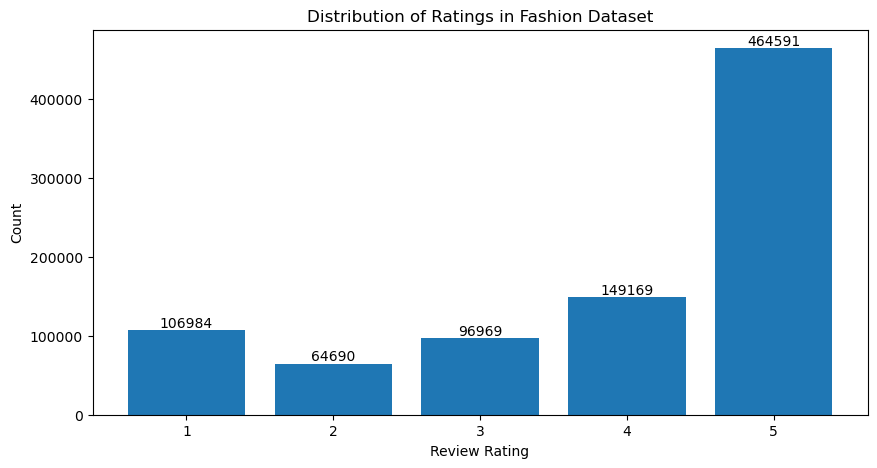

90th Percentile Length: 334.0
Minimum Length: 1
Maximum Length: 10565
Mean Length: 147.7904721538798
Median Length: 88.0
Review with Minimum Length:
 A

Review with Maximum Length:
 this product is just so amazing and terrific and I love it a lot it truly is just a terrific product and I would probably order it again that great I love all of its features and it's attribute you just terrific and it's great quality to do real bang for your buck if you know what I mean I'd recommend this product to my close friends too it's very good. it's a great product good price terrific buy with great features and qualities that make it appear year to all others and it's genre I really like the product and I would buy it again it just product and a real bang for your buck! this product is just so amazing and terrific and I love it a lot it truly is just a terrific product and I would probably order it again that great I love all of its features and it's attribute you just terrific and it's great qual

In [15]:
fashion_df = dataset_EDA_and_preprocessing(amazon_fashion_df)

Dataset before DropNA:
            overall
count  34278.00000
mean       4.28616
std        1.03736
min        1.00000
25%        4.00000
50%        5.00000
75%        5.00000
max        5.00000

Dataset after DropNA:
             overall
count  34265.000000
mean       4.286181
std        1.037412
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000


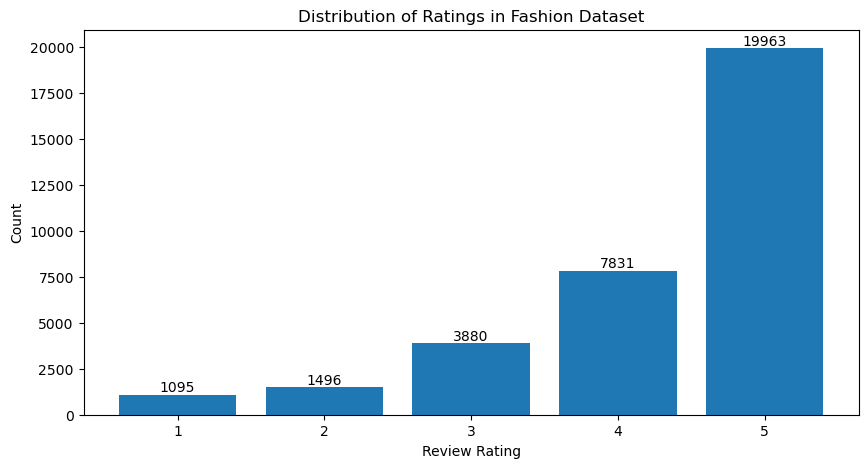

90th Percentile Length: 1106.0
Minimum Length: 2
Maximum Length: 16970
Mean Length: 489.144024514811
Median Length: 321.0
Review with Minimum Length:
 ok

Review with Maximum Length:
 the loreal dermablend professional line of cosmetics is new to me.  they earn being in a high-end category in my opinion. they do not seem to be scented or too chemical. the jars, tubes, compacts are made very sturdy to last along with your make-ups. i have many favorites among them, yet i believe they all stand very well on their own.

i hope it is going to be efficient to review all of the ones i know of here, and including compatible products along the way. respectively:

1. l'oreal dermablend professional cover cr&egrave;me with titanium dioxide sunscreen (30spf):
2. loreal dermablend professional translucent loose setting powder (no spf):
3. loreal dermablend professional set + refresh long-lasting make-up setting spray (no spf):
4. loreal dermablend professional smooth liquid camo medium cover found

In [14]:
luxury_testset = dataset_EDA_and_preprocessing(luxury_df)

Both datasets are very imbalanced. The training and validation set will be balanced.

In [16]:
balanced_df = balance_dataset(fashion_df, 10000)


overall
5    10000
2    10000
4    10000
3    10000
1    10000
Name: count, dtype: int64


In [17]:
# Defining the target variable
y = balanced_df['overall']

# Split the data into training and validation sets
df_xtrain, df_xval, df_ytrain, df_yval = train_test_split(balanced_df, y, test_size=0.1, random_state=42, stratify=y)
df_xtrain = df_xtrain.reset_index(drop=True)
df_xval = df_xval.reset_index(drop=True)
df_ytrain = df_ytrain.reset_index(drop=True)
df_yval = df_yval.reset_index(drop=True)

In [18]:
y_test = luxury_testset['overall']
x_test = luxury_testset['reviewText']


In [ ]:
print(x_test.head())
print(y_test.head())

print(len(df_xtrain), len(df_xval), len(x_test), len(y_test))

In [19]:
max_tokens = 4000
sentence_length = 400 #around the length of the 90th percentile
encoder = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',  # This ensures the output is an integer sequence
    output_sequence_length=sentence_length)  # Specify the desired output sequence length

encoder.adapt(df_xtrain['reviewText'].values)  # Use values instead of map for a NumPy array

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'for', 'my',
       'of', 'but', 'in', 'was', 'not', 'this', 'they', 'on', 'that'],
      dtype='<U25')

In [20]:
# Convert target data to one-hot encoding for multi-class classification
# Convert target data to one-hot encoding for multi-class classification
df_ytrain_one_hot = tf.keras.utils.to_categorical(df_ytrain - 1, num_classes=5)
df_yval_one_hot = tf.keras.utils.to_categorical(df_yval - 1, num_classes=5)

y_test_one_hot = tf.keras.utils.to_categorical(y_test-1, num_classes=5)

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi LSTM(16),1 layer,')
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=10,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(256),Embedding = 256, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(512),Embedding = 256, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(512),Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(256),Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
)

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'GRU(256),Embedding = 256, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'GRU(512),Embedding = 256, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'GRU(256),Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'GRU(512),Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
  )

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(512),GRU(512),Embedding = 512, T = 4000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'GRU(512),GRU(512),Embedding = 512, T = 2000, L=200')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.GRU(512, return_sequences=True),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = '100perc. fashion data, GRU(512),Dropout,Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

In [ ]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'Bidi GRU(512),Dropout,Embedding = 512, T = 2000, L=400')

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=30,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback()])

Below code block trains our final model and saves it. 

In [21]:
tf.keras.backend.clear_session()
wandb.init(project= 'RNN Experiments 1',
           name = 'FINAL MODEL: 10.000 per rating train, Bidi GRU(512),Bidi GRU(512),Embedding = 512, T = 4000, L=400')

early_stopping = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights = True)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

history = model.fit(
    df_xtrain['reviewText'],
    df_ytrain_one_hot,
    epochs=75,
    validation_data=(df_xval['reviewText'], df_yval_one_hot),
    callbacks = [WandbCallback(), early_stopping])

model.save('Final_Model_Bidi_GRU(512)_GRU(512)_Embedding_512_T_4000_L_400.keras')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nsjensen (arghstress). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 400, 512)          2048000   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 1024)        3151872   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             4724736   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                        

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/75
1407/1407 [==============================] - ETA: 0s - loss: 1.1076 - accuracy: 0.5067 - auc: 0.8365 - precision: 0.6462 - recall: 0.2978

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best)... Done. 0.3s


1407/1407 [==============================] - 248s 166ms/step - loss: 1.1076 - accuracy: 0.5067 - auc: 0.8365 - precision: 0.6462 - recall: 0.2978 - val_loss: 0.9925 - val_accuracy: 0.5734 - val_auc: 0.8716 - val_precision: 0.7029 - val_recall: 0.3672
Epoch 2/75
1406/1407 [============================>.] - ETA: 0s - loss: 0.9125 - accuracy: 0.6072 - auc: 0.8908 - precision: 0.6861 - recall: 0.4738

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best)... Done. 0.3s


1407/1407 [==============================] - 227s 161ms/step - loss: 0.9125 - accuracy: 0.6072 - auc: 0.8908 - precision: 0.6861 - recall: 0.4738 - val_loss: 0.9885 - val_accuracy: 0.5746 - val_auc: 0.8751 - val_precision: 0.6454 - val_recall: 0.4758
Epoch 3/75
1407/1407 [==============================] - ETA: 0s - loss: 0.7926 - accuracy: 0.6669 - auc: 0.9179 - precision: 0.7243 - recall: 0.5800

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\nille\Documents\GitHub\amlexam\wandb\run-20240130_205758-26ryt87j\files\model-best)... Done. 0.3s


1407/1407 [==============================] - 236s 168ms/step - loss: 0.7926 - accuracy: 0.6669 - auc: 0.9179 - precision: 0.7243 - recall: 0.5800 - val_loss: 0.9392 - val_accuracy: 0.6192 - val_auc: 0.8894 - val_precision: 0.6646 - val_recall: 0.5362
Epoch 4/75
1407/1407 [==============================] - 179s 127ms/step - loss: 0.6643 - accuracy: 0.7270 - auc: 0.9422 - precision: 0.7689 - recall: 0.6693 - val_loss: 0.9696 - val_accuracy: 0.6372 - val_auc: 0.8934 - val_precision: 0.6754 - val_recall: 0.5792
Epoch 5/75
1407/1407 [==============================] - 184s 131ms/step - loss: 0.5255 - accuracy: 0.7859 - auc: 0.9634 - precision: 0.8190 - recall: 0.7495 - val_loss: 0.9949 - val_accuracy: 0.6420 - val_auc: 0.8944 - val_precision: 0.6780 - val_recall: 0.5966
Epoch 6/75
1407/1407 [==============================] - 181s 129ms/step - loss: 0.4022 - accuracy: 0.8386 - auc: 0.9782 - precision: 0.8637 - recall: 0.8152 - val_loss: 1.1053 - val_accuracy: 0.6490 - val_auc: 0.8953 - val_pr

INFO:tensorflow:Assets written to: Final Model Bidi GRU(512),GRU(512),Embedding = 512, T = 4000, L=400\assets


INFO:tensorflow:Assets written to: Final Model Bidi GRU(512),GRU(512),Embedding = 512, T = 4000, L=400\assets


In [23]:
wandb.init(project='RNN test',
           name='Final model test')

evaluation_results = model.evaluate(x=x_test, y=y_test_one_hot)

print(evaluation_results)
dict_of_result = {'loss':evaluation_results[0], 
                  'accuracy':evaluation_results[1], 
                  'AUC':evaluation_results[2], 
                  'Precision':evaluation_results[3], 
                  'Recall':evaluation_results[4]}

wandb.log(dict_of_result)

accuracy,▁▃▄▅▆▇▇█████████▇▅▅▆▇▆▆
auc,▁▃▅▆▇▇███████████▆▆▇▇▇▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▂▄▄▄▃▃▃
precision,▁▂▃▄▅▆▇▇████████▇▅▅▅▆▆▆
recall,▁▃▄▅▆▇▇█████████▇▆▆▆▇▇▇
val_accuracy,▁▁▅▆▆▇█▇█████▇▇▇▅▃▄▅▄▅▅
val_auc,▂▂▆▇██▅▃▅▄▃▂▂▂▂▃▁▁▃▅▂▃▃
val_loss,▂▂▁▁▂▃▅▆▆▇▇▇█▇▇▆▃▃▂▃▅▄▄
val_precision,█▂▄▅▆▅▅▅▅▅▅▆▅▄▄▅▂▁▂▄▁▃▃
val_recall,▁▄▅▆▇▇██████████▆▅▆▇▆▇▇


1071/1071 [==============================] - 71s 66ms/step - loss: 1.5836 - accuracy: 0.4340 - auc: 0.7571 - precision: 0.4814 - recall: 0.3646
[1.5835689306259155, 0.4339997172355652, 0.757129430770874, 0.48142439126968384, 0.3645702600479126]


In [24]:
wandb.finish()

AUC,▁
Precision,▁
Recall,▁
accuracy,▁
loss,▁
AUC,0.75713
Precision,0.48142
Recall,0.36457
accuracy,0.434
loss,1.58357


In [27]:
y_test_pred = model.predict(x_test)

1071/1071 [==============================] - 72s 63ms/step


In [28]:
y_test_predictions_class = np.argmax(y_test_pred, axis=1) + 1

Predicted Class Labels:
[2 4 2 ... 1 5 4]


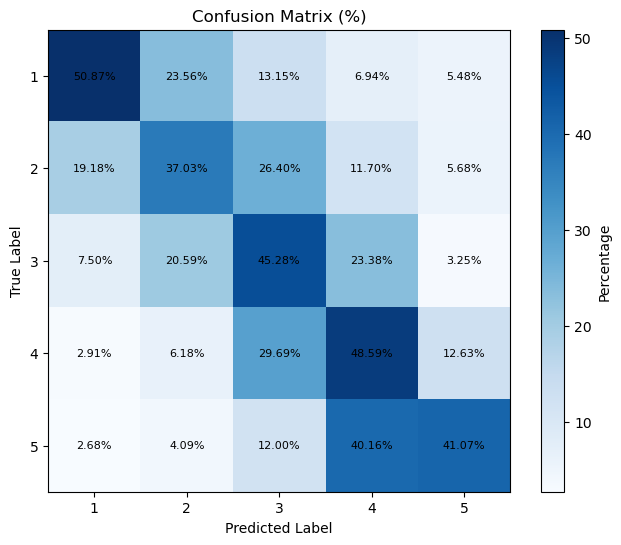

In [29]:
cm = confusion_matrix(y_test, y_test_predictions_class)

#Calculate percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

#Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Percentage')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")

#Add annotations
for i in range(len(cm_percent)):
    for j in range(len(cm_percent[i])):
        plt.text(j, i, f'{cm_percent[i, j]:.2f}%', ha='center', va='center', color='black', fontsize=8)

plt.xticks(range(5), labels=range(1, 6))
plt.yticks(range(5), labels=range(1, 6))

plt.show()